<a href="https://colab.research.google.com/github/robertoricci/Curso-Python-para-Mercado-Financeiro-Trading-com-Dados/blob/main/Modulo_8_Analise_Quantitativa%20-%20Portifolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center> Markowitz com Python<center>
    
- Coleta de dados do Yahoo Finance
- Problema de otimização
- Plotagem da Fronteira de Pareto    

# <center>Selecionando os ativos<center>

In [217]:
import requests
import pandas as pd
import yfinance as yf
import requests
import json
from datetime import datetime

In [218]:
#baixar composição direto da b3
def composicao_carteira_B3():
  # da B3
  # https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-composicao-da-carteira.htm

  url = 'https://sistemaswebb3-listados.b3.com.br/indexProxy/indexCall/GetPortfolioDay/eyJsYW5ndWFnZSI6InB0LWJyIiwicGFnZU51bWJlciI6MSwicGFnZVNpemUiOjEyMCwiaW5kZXgiOiJJQk9WIiwic2VnbWVudCI6IjEifQ=='

  r = requests.get(url)
  pd.json_normalize(json.loads(r.content))
  comp_ibov =  pd.json_normalize(json.loads(r.content), record_path =['results'])
  comp_ibov.drop(columns=['segment', 'partAcum'], inplace=True)
  #ordernar pelo codigo da empresa
  comp_ibov.sort_values(by=['cod'], ascending=True, inplace=True)
  comp_ibov['part'] = comp_ibov['part'].apply(lambda x: float(x.replace(',', '.')))
  comp_ibov['theoricalQty'] = comp_ibov['theoricalQty'].apply(lambda x: int(x.replace('.', '')))

  return comp_ibov

In [219]:
#baixar composição atual do B3
df_ibovespa = composicao_carteira_B3()

In [220]:
df_ibovespa

,cod,asset,type,part,theoricalQty
3,ABEV3,AMBEV S/A,ON EJ,2.637,4394245879
1,ALOS3,ALLOS,ON NM,0.618,532616595
2,ALPA4,ALPARGATAS,PN N1,0.078,176733968
4,ARZZ3,AREZZO CO,ON NM,0.176,62305891
5,ASAI3,ASSAI,ON NM,0.798,1349217892
...,...,...,...,...,...
83,VAMO3,VAMOS,ON EJ NM,0.185,421383330
84,VBBR3,VIBRA,ON EJ NM,1.109,1114412532
76,VIVT3,TELEF BRASIL,ON EJ,0.988,423091712
85,WEGE3,WEG,ON NM,2.390,1481593024


In [221]:
ativos = df_ibovespa['cod'].values

In [222]:
len(ativos)

87

# <center> Série histórica de retornos <center>

In [223]:
import yfinance as yf

In [224]:
start = '2023-01-01'
end = '2023-12-30'

In [225]:
#adicionar o .SA nos ativos
ativos = (df_ibovespa['cod'].values+'.SA').tolist()

In [226]:
fechamentos = yf.download(tickers = ativos, start = start, end = end)['Adj Close']

[*********************100%%**********************]  87 of 87 completed


A configuração method="backfill" preenche todos os valores NaN de DataFrame com o valor após o valor NaN na mesma coluna.

In [227]:
fechamentos = fechamentos.fillna(method="backfill")


In [228]:
retornos = fechamentos.pct_change()

In [229]:
retornos

,ABEV3.SA,ALOS3.SA,ALPA4.SA,ARZZ3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,...,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VAMO3.SA,VBBR3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.001409,0.000000,-0.064899,-0.031166,-0.020011,-0.013592,-0.033469,-0.018641,-0.047276,-0.049625,...,-0.034376,-0.024144,-0.015899,-0.011380,-0.001790,-0.056847,-0.029932,-0.020061,-0.024934,-0.063330
2023-01-04,0.005646,0.000000,0.006716,0.022977,0.025255,0.039370,0.007601,0.012868,0.008765,0.002857,...,0.029200,0.000900,0.023809,0.020144,0.001793,0.024657,0.029453,0.021873,0.006729,0.013086
2023-01-05,0.002807,0.000000,0.027428,0.011979,-0.005241,0.093750,0.031014,0.045674,0.032386,0.043447,...,0.045472,-0.006292,0.013289,0.059238,0.016778,0.024956,0.004768,0.026894,0.002139,0.012917
2023-01-06,0.002099,0.000000,0.000722,0.019640,0.003161,0.025108,0.023577,0.013885,0.026779,0.027986,...,0.016357,-0.012212,0.011476,0.010652,0.015842,0.037391,0.006780,0.021379,0.014675,0.036132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,-0.002911,0.025048,-0.022484,0.010848,-0.008982,0.035985,0.022583,0.001476,-0.000646,0.000579,...,0.008772,0.003948,0.019806,0.037500,0.033293,0.030526,0.029006,-0.005050,0.006361,0.007916
2023-12-22,0.000730,-0.007519,0.040526,0.007406,0.012840,-0.006703,0.001380,0.002763,0.002486,0.003102,...,-0.014993,0.006292,0.001523,0.016429,-0.007535,-0.006129,0.007159,0.007143,0.003298,-0.027923
2023-12-26,0.004376,0.008712,0.026316,-0.003751,-0.002983,-0.002454,0.010338,0.009184,0.003987,0.002971,...,0.020700,-0.001172,0.002662,0.004310,0.003535,0.007194,0.011020,0.005039,0.005752,0.005386


In [230]:
retornos.columns = retornos.columns.str.rstrip('.SA')
retornos

,ABEV3,ALOS3,ALPA4,ARZZ3,ASAI3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,...,TOTS3,TRPL4,UGPA3,USIM5,VALE3,VAMO3,VBBR3,VIVT3,WEGE3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.001409,0.000000,-0.064899,-0.031166,-0.020011,-0.013592,-0.033469,-0.018641,-0.047276,-0.049625,...,-0.034376,-0.024144,-0.015899,-0.011380,-0.001790,-0.056847,-0.029932,-0.020061,-0.024934,-0.063330
2023-01-04,0.005646,0.000000,0.006716,0.022977,0.025255,0.039370,0.007601,0.012868,0.008765,0.002857,...,0.029200,0.000900,0.023809,0.020144,0.001793,0.024657,0.029453,0.021873,0.006729,0.013086
2023-01-05,0.002807,0.000000,0.027428,0.011979,-0.005241,0.093750,0.031014,0.045674,0.032386,0.043447,...,0.045472,-0.006292,0.013289,0.059238,0.016778,0.024956,0.004768,0.026894,0.002139,0.012917
2023-01-06,0.002099,0.000000,0.000722,0.019640,0.003161,0.025108,0.023577,0.013885,0.026779,0.027986,...,0.016357,-0.012212,0.011476,0.010652,0.015842,0.037391,0.006780,0.021379,0.014675,0.036132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,-0.002911,0.025048,-0.022484,0.010848,-0.008982,0.035985,0.022583,0.001476,-0.000646,0.000579,...,0.008772,0.003948,0.019806,0.037500,0.033293,0.030526,0.029006,-0.005050,0.006361,0.007916
2023-12-22,0.000730,-0.007519,0.040526,0.007406,0.012840,-0.006703,0.001380,0.002763,0.002486,0.003102,...,-0.014993,0.006292,0.001523,0.016429,-0.007535,-0.006129,0.007159,0.007143,0.003298,-0.027923
2023-12-26,0.004376,0.008712,0.026316,-0.003751,-0.002983,-0.002454,0.010338,0.009184,0.003987,0.002971,...,0.020700,-0.001172,0.002662,0.004310,0.003535,0.007194,0.011020,0.005039,0.005752,0.005386


In [231]:
#Excluir os valores NaN
retornos.dropna(inplace=True)

In [232]:
#229 dias e 87 ativos
retornos.shape

(247, 87)

# <center>Modelagem da otimização<center>
    
$$\mathrm{\min} \,\,\, x^TCov\,\, x\,\,\,\,\mathrm{\max} \,\,\, \mu^Tx$$

<center>sujeito a<center>

$$\displaystyle\sum_{i=1}^n x_i=1$$

$$x_i\geq0, i=1,\cdots,n$$
    
$$x_i\leq1, i=1,\cdots,n$$    
    
## <center>Otimização ponderada <center>

$$\mathrm{\min} \,\,\, \alpha x^TCov\,\, x - (1-\alpha) \mu^Tx$$

<center>sujeito a<center>

$$[1,\cdots,1]_{1\times n}x=1$$

$$0\leq x_i\leq 1, i=1,\cdots,n$$
    
    
## <center>Código em Python<center>   
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

## <center>Parâmetros<center>

In [233]:
[tam, qtd_ativos ] = retornos.shape

In [234]:
import numpy as np

In [235]:
qtd_pts_fronteira = 100
PONTOS_FRONT = np.linspace(0,1,qtd_pts_fronteira)
cov = retornos.cov()

In [236]:
PONTOS_FRONT

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [237]:
cov

,ABEV3,ALOS3,ALPA4,ARZZ3,ASAI3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,...,TOTS3,TRPL4,UGPA3,USIM5,VALE3,VAMO3,VBBR3,VIVT3,WEGE3,YDUQ3
ABEV3,0.000172,0.000020,0.000118,0.000108,0.000099,0.000217,0.000108,0.000069,0.000088,0.000097,...,0.000095,0.000048,0.000085,0.000058,0.000032,0.000138,0.000088,0.000058,0.000059,0.000095
ALOS3,0.000020,0.000051,0.000043,0.000050,0.000058,0.000072,0.000048,0.000021,0.000026,0.000027,...,0.000035,0.000022,0.000013,0.000018,0.000011,0.000070,0.000021,0.000010,0.000026,0.000057
ALPA4,0.000118,0.000043,0.001181,0.000430,0.000304,0.000592,0.000311,0.000109,0.000241,0.000291,...,0.000244,0.000116,0.000177,0.000208,0.000130,0.000355,0.000289,0.000109,0.000105,0.000534
ARZZ3,0.000108,0.000050,0.000430,0.000699,0.000321,0.000561,0.000342,0.000143,0.000205,0.000228,...,0.000232,0.000079,0.000121,0.000188,0.000128,0.000442,0.000277,0.000107,0.000134,0.000522
ASAI3,0.000099,0.000058,0.000304,0.000321,0.000780,0.000473,0.000202,0.000103,0.000142,0.000153,...,0.000236,0.000120,0.000107,0.000106,0.000071,0.000365,0.000200,0.000107,0.000131,0.000314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAMO3,0.000138,0.000070,0.000355,0.000442,0.000365,0.000625,0.000383,0.000162,0.000246,0.000282,...,0.000276,0.000139,0.000135,0.000207,0.000155,0.000910,0.000294,0.000116,0.000155,0.000446
VBBR3,0.000088,0.000021,0.000289,0.000277,0.000200,0.000362,0.000253,0.000120,0.000154,0.000175,...,0.000192,0.000057,0.000240,0.000109,0.000085,0.000294,0.000490,0.000065,0.000058,0.000373
VIVT3,0.000058,0.000010,0.000109,0.000107,0.000107,0.000195,0.000110,0.000068,0.000076,0.000085,...,0.000107,0.000046,0.000054,0.000049,0.000022,0.000116,0.000065,0.000183,0.000053,0.000157
WEGE3,0.000059,0.000026,0.000105,0.000134,0.000131,0.000143,0.000110,0.000033,0.000059,0.000049,...,0.000078,0.000037,0.000022,0.000060,0.000041,0.000155,0.000058,0.000053,0.000254,0.000083


In [238]:
media_retornos = retornos.mean().values
media_retornos

array([ 1.58437689e-04,  7.88435489e-04, -8.14559352e-04, -9.33664665e-05,
       -9.71405169e-04,  2.93254456e-03,  1.04147116e-03,  2.50710471e-03,
        1.11179875e-03,  1.15870778e-03,  5.29978894e-04, -1.52683720e-03,
       -4.69293098e-03,  2.44693571e-03,  2.85111100e-05,  2.96234859e-03,
        2.50134466e-04,  1.48569433e-03,  1.15556646e-04,  7.82253449e-04,
        3.48509963e-03,  2.57088578e-03,  1.18232818e-03,  1.49594126e-03,
       -4.19842806e-05,  1.12723275e-03,  1.86326470e-03,  4.81849036e-04,
        3.03007488e-03,  1.30318031e-03,  1.12288944e-03,  3.83158790e-04,
        7.68120230e-04,  2.01558710e-03,  9.82426550e-04,  1.24731032e-03,
        1.40713083e-03,  1.95047645e-03,  1.18228217e-03, -1.65084291e-04,
        3.44550345e-04,  1.96646770e-03,  1.24931071e-03, -5.19743245e-04,
        1.55091577e-03,  3.00160538e-03,  1.44778182e-03,  1.61747734e-03,
        1.03432176e-03,  7.77780958e-04,  1.91597683e-04,  4.79818342e-04,
        4.30213976e-04,  

### <center>Verificando se a matriz de covariância é Definida Positiva<center>

In [239]:
def is_pos_def(A):
    M = np.matrix(A)
    return np.all(np.linalg.eigvals(M)>0)

In [240]:
is_pos_def(cov)  #A matriz de covariância é definida positiva, então a função variância é convexa, de forma que está OK
                #utilizar o método de otimização multiobjetivo por escalarização --> o método será capaz de gerar a
                #Fronteira de Pareto

True

## <center>Preparando para o Python<center>
    
- Bounds: $lb \leq x \leq ub$
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.Bounds.html    

In [241]:
from scipy.optimize import Bounds

In [242]:
bnds = Bounds(np.zeros(qtd_ativos), np.ones(qtd_ativos))

## <center>Restrição de igualdade<center>  

In [243]:
def h(x):
    return sum(x)-1

In [244]:
cons = ({'type':'eq','fun':h})

## <center>Solução inicial<center>

In [245]:
x0 = (1/qtd_ativos)*np.ones(qtd_ativos)

In [246]:
##gerar os pesos
sum(x0)

0.999999999999999

## <center>Funções objetivo<center>

In [247]:
media_retornos

array([ 1.58437689e-04,  7.88435489e-04, -8.14559352e-04, -9.33664665e-05,
       -9.71405169e-04,  2.93254456e-03,  1.04147116e-03,  2.50710471e-03,
        1.11179875e-03,  1.15870778e-03,  5.29978894e-04, -1.52683720e-03,
       -4.69293098e-03,  2.44693571e-03,  2.85111100e-05,  2.96234859e-03,
        2.50134466e-04,  1.48569433e-03,  1.15556646e-04,  7.82253449e-04,
        3.48509963e-03,  2.57088578e-03,  1.18232818e-03,  1.49594126e-03,
       -4.19842806e-05,  1.12723275e-03,  1.86326470e-03,  4.81849036e-04,
        3.03007488e-03,  1.30318031e-03,  1.12288944e-03,  3.83158790e-04,
        7.68120230e-04,  2.01558710e-03,  9.82426550e-04,  1.24731032e-03,
        1.40713083e-03,  1.95047645e-03,  1.18228217e-03, -1.65084291e-04,
        3.44550345e-04,  1.96646770e-03,  1.24931071e-03, -5.19743245e-04,
        1.55091577e-03,  3.00160538e-03,  1.44778182e-03,  1.61747734e-03,
        1.03432176e-03,  7.77780958e-04,  1.91597683e-04,  4.79818342e-04,
        4.30213976e-04,  

In [248]:
#Calcula o retorno de um portfólio --> variável é o vetor de pesos --> saída: um número (retorno)
def calcula_retorno(x):
    return media_retornos.dot(x)

In [249]:
#Calcula o risco de um portfólio --> variável é o vetor de pesos --> saída: um número (risco)
def calcula_risco(x):
    return (x.dot(cov.values)).dot(x)

## <center>Algoritmo de otimização<center>

In [250]:
from scipy.optimize import minimize

In [251]:
def realiza_otimizacao(aux_ponto_front):
    def funcao_objetivo(x, ponto_front=aux_ponto_front):
        retorno = calcula_retorno(x)
        risco = calcula_risco(x)
        return ponto_front*risco-(1-ponto_front)*retorno

    xmin = minimize(funcao_objetivo, x0, bounds = bnds, constraints = cons)
    return xmin.x

In [252]:
PONTOS_FRONT

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [253]:
PONTOS_FRONT

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [254]:
def constroi_fronteira():
    carteiras_front = []
    retorno = np.zeros(qtd_pts_fronteira)
    risco = np.zeros(qtd_pts_fronteira)
    pos = 0
    for ponto_front in PONTOS_FRONT:
        carteira = realiza_otimizacao(ponto_front)
        carteiras_front.append(carteira)
        retorno[pos] = calcula_retorno(carteira)
        risco[pos] = calcula_risco(carteira)
        pos += 1
    return retorno, risco, carteiras_front

In [255]:
retorno, risco, carteiras_front = constroi_fronteira()

# <center>Gráfico - Fronteira de Pareto<center>

In [256]:
import matplotlib.pyplot as plt

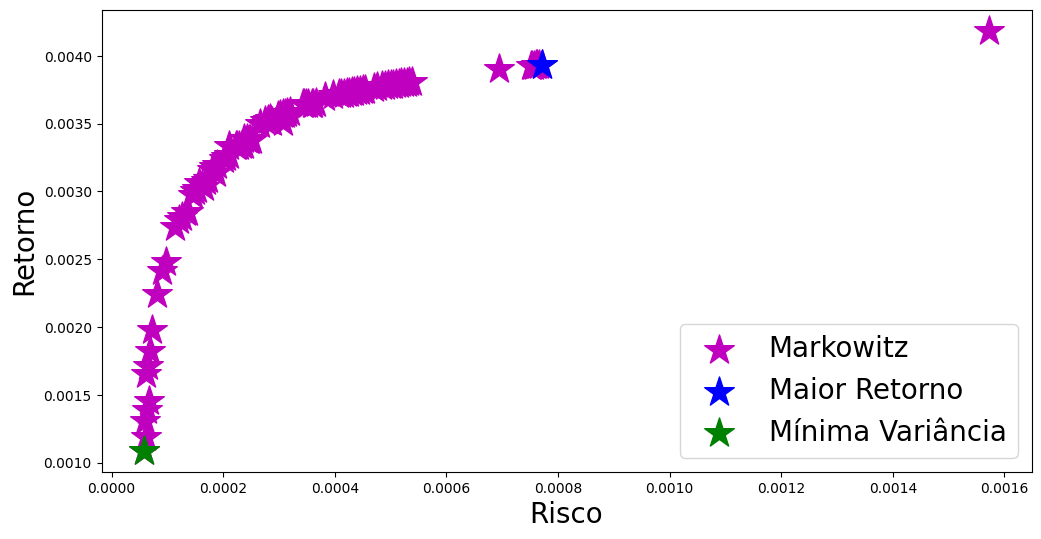

In [257]:
plt.figure(figsize=(12,6))
plt.scatter(risco, retorno,marker='*', s = 500, c='m',label='Markowitz')
plt.scatter(risco[0], retorno[0],marker='*', s = 500, c='b',label='Maior Retorno')
plt.scatter(risco[-1], retorno[-1],marker='*', s = 500, c='g',label='Mínima Variância')
plt.xlabel('Risco', fontsize = 20)
plt.ylabel('Retorno', fontsize = 20)
legend = plt.legend(loc='lower right', fontsize = 20)

# <center>Comparando com o Ibovespa<center>

In [258]:
df_ibovespa.head()

,cod,asset,type,part,theoricalQty
3,ABEV3,AMBEV S/A,ON EJ,2.637,4394245879
1,ALOS3,ALLOS,ON NM,0.618,532616595
2,ALPA4,ALPARGATAS,PN N1,0.078,176733968
4,ARZZ3,AREZZO CO,ON NM,0.176,62305891
5,ASAI3,ASSAI,ON NM,0.798,1349217892


In [259]:
portfolio_ibovespa = df_ibovespa['part'].values/100

In [260]:
risco_ibovespa = calcula_risco(portfolio_ibovespa)

In [261]:
retorno_ibovespa = calcula_retorno(portfolio_ibovespa)

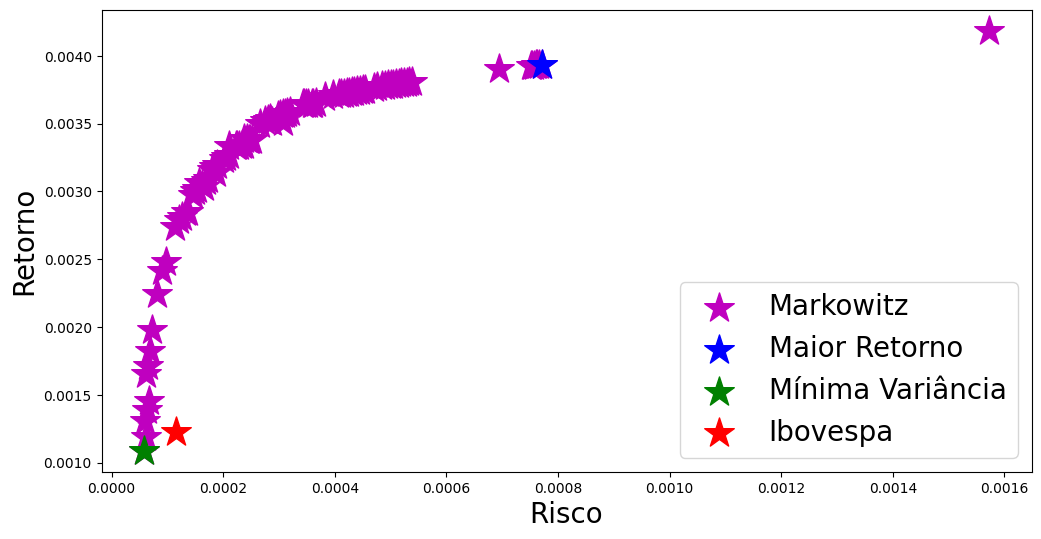

In [262]:
plt.figure(figsize=(12,6))
plt.scatter(risco, retorno,marker='*', s = 500, c='m',label='Markowitz')
plt.scatter(risco[0], retorno[0],marker='*', s = 500, c='b',label='Maior Retorno')
plt.scatter(risco[-1], retorno[-1],marker='*', s = 500, c='g',label='Mínima Variância')
plt.scatter(risco_ibovespa, retorno_ibovespa,marker='*', s = 500, c='r',label='Ibovespa')
plt.xlabel('Risco', fontsize = 20)
plt.ylabel('Retorno', fontsize = 20)
legend = plt.legend(loc='lower right', fontsize = 20)